## General information

We all know that feature engineering is the most important things in competitions. If you have deep domain knowledge, you can create better features!

Sadly, I have little domain knowledge (last time I paid attention to chemical formulas was in school)...

So I'll to create a lot of features and hope that some of them work!

**Important!**
I have realized the main problem of features in my previous [kernel](https://www.kaggle.com/artgor/molecular-properties-eda-and-models): I created features based on the whole train/test set, but it makes much more sense to generate features based on molecules (for example mean distance per molecules). Let's try this!

![](https://imgs.xkcd.com/comics/machine_learning.png)

~Thanks to the new kaggle update we can write code in kernels and import it. This is much more convenient and useful. I'm moving all the functions I can into this script: https://www.kaggle.com/artgor/artgor-utils So if you see somewhere code like artgot_utils.function_name(parameters) - it is from this script~
**Important**:
It seems that after forking the utility script isn't copied, so I have decided to move all the functions back into the kernel. But utility kernel can't be removed from the kernel... I hope I was able to deal with it.

In [42]:
!pip install -U vega_datasets notebook vega

Requirement already up-to-date: vega_datasets in c:\programfiles\anaconda\lib\site-packages (0.7.0)
Requirement already up-to-date: notebook in c:\programfiles\anaconda\lib\site-packages (6.0.0)
Requirement already up-to-date: vega in c:\programfiles\anaconda\lib\site-packages (2.5.0)


importing libraries

In [43]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

all functions

In [44]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

## New heading

## Data loading and overview

In [45]:
file_folder = '../input/champs-scalar-coupling' if 'champs-scalar-coupling' in os.listdir('../input/') else '../input'
os.listdir(file_folder)

['dipole_moments.csv',
 'magnetic_shielding_tensors.csv',
 'mulliken_charges.csv',
 'potential_energy.csv',
 'sample_submission.csv',
 'scalar_coupling_contributions.csv',
 'structures',
 'structures.csv',
 'test.csv',
 'train.csv']

We have a lot of files, let's focus on the main ones for now.

In [46]:
np.set_printoptions(precision=15)

In [47]:
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

## Filter

In [48]:
filter_size = 0.9
from sklearn.model_selection import train_test_split
train, _ = train_test_split(train, test_size=filter_size, random_state=42)
test, _ = train_test_split(test, test_size=filter_size, random_state=42)
sub, _ = train_test_split(sub, test_size=filter_size, random_state=42)

In [49]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
4459764,4459764,dsgdb9nsd_123505,14,8,1JHC,137.375000000000000
3759061,3759061,dsgdb9nsd_107252,19,5,3JHC,2.246280000000000
3146423,3146423,dsgdb9nsd_091755,14,8,3JHC,6.388150000000000
2744081,2744081,dsgdb9nsd_082036,13,3,1JHC,109.662999999999997
4246150,4246150,dsgdb9nsd_118716,12,1,2JHC,0.115294000000000


In [50]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


In [51]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 465814 rows in train data.
There are 250554 rows in test data.
There are 83300 distinct molecules in train data.
There are 44772 distinct molecules in test data.
There are 28 unique atoms.
There are 8 unique types.


## Basic feature engineering

Code for joining data is from this kernel:
https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [52]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

distances

In [53]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

I want to create two new features: one will show the first character of the `type`, the second one will show other characters.

In [54]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

I calculated these three features in my previous kernel... But they are hardly useful - they contain statistics on all the dataset

In [55]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 63.08 Mb (11.2% reduction)
Mem. usage decreased to 32.02 Mb (11.8% reduction)


## Much more features

I have decided to create a lot of features:
- these features calculate statistics per molecules;
- several features are calculated for molecules in general;
- most features are calculated for molecules and one of categorical variables;
- I wanted to use all combinations of features and more aggregates, but kernel RAM isn't enough :( 
- also I wanted to calculated differences between aggregated and original values

You can see the code to generate all features (400+) below in function `create_features_full`. I generated all these features, trained an lgb and selected top-50 features. I'll generate them now.

I'd upload all the generated features on Kaggle dataset, but the total size of train and test data exceeds the allowed limits :(

In [56]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]

    df = reduce_mem_usage(df)
    return df

Generating subsert of features for this kernel.

In [57]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df

In [58]:
train = create_features(train)

Mem. usage decreased to 242.11 Mb (3.7% reduction)


In [59]:
test = create_features(test)

Mem. usage decreased to 128.31 Mb (3.8% reduction)


In [60]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,4459764,dsgdb9nsd_123505,14,8,1JHC,137.375000000000000,H,-0.8983192664,-0.6460917290,0.0074315950,...,-0.134897531938892,NaN,NaN,1.078930106802974,0.000000000000000,1.000000000000000,1.078930106802974,1.078930106802974,NaN,NaN
1,3759061,dsgdb9nsd_107252,19,5,3JHC,2.246280000000000,H,-1.1640457630,0.4533974521,-4.2285289040,...,-2.136373531200340,0.439814185133447,-2.498097175792555,3.072311219531439,0.134399858605437,1.045746737084360,3.627776615622883,2.773951145619294,0.378893341519713,-2.559018019406289
2,3146423,dsgdb9nsd_091755,14,8,3JHC,6.388150000000000,H,1.2123506210,0.3683805283,-1.8232093740,...,-1.826212624836452,0.453518885425092,-2.158709575585157,3.226568025519518,0.614339564509269,1.235178344344231,3.461375345123267,2.612228461010249,0.326779702984987,-2.285448758025262
3,2744081,dsgdb9nsd_082036,13,3,1JHC,109.662999999999997,H,3.0343908390,-0.2083376176,-1.5810364530,...,0.299965967106754,NaN,NaN,1.085408113786139,0.000000000000000,1.000000000000000,1.085408113786139,1.085408113786139,NaN,NaN
4,4246150,dsgdb9nsd_118716,12,1,2JHC,0.115294000000000,H,-2.2132475790,-0.1468023989,0.0143238287,...,-1.602304074269146,0.193603513401183,-1.967622279418319,2.198070978989648,0.036845186170146,1.017048281717052,2.284438237266766,2.148548906882676,0.075064327986026,-2.086161464833476
5,4606141,dsgdb9nsd_130227,12,6,1JHC,116.319000000000003,H,2.6336629680,-3.1737816050,-0.0384652754,...,-0.222792487696371,NaN,NaN,1.088618224812996,0.000000000000000,1.000000000000000,1.088618224812996,1.088618224812996,NaN,NaN
6,315959,dsgdb9nsd_011005,16,6,2JHC,0.568731000000000,H,1.1165943030,-1.5487205660,-0.6790031558,...,-1.545061910007964,0.245488423492626,-1.835971719126192,2.199040792755719,0.117580650136900,1.056489503560210,2.302447175326253,2.081460142618818,0.111173286143711,-1.970286856475107
7,2140040,dsgdb9nsd_066787,17,6,2JHN,3.945640000000000,H,-2.2630065880,-0.4562702312,0.6419031045,...,NaN,0.012779397158269,-2.270800829602988,2.283580226761257,0.000000000000000,1.000000000000000,2.283580226761257,2.283580226761257,NaN,NaN
8,1320194,dsgdb9nsd_042790,12,1,2JHC,-3.259700000000000,H,2.0473048090,2.0597313190,0.3901172498,...,-1.516952113254987,0.366809541411931,-1.941069929836329,2.307879471248260,0.000000000000000,1.000000000000000,2.307879471248260,2.307879471248260,NaN,NaN
9,198758,dsgdb9nsd_007402,12,5,2JHC,-2.684740000000000,H,0.5572096747,-3.8808408120,-2.2201929990,...,-1.539669457766023,0.051126853005810,-1.997793186514404,2.106262111235141,0.057342071714928,1.027986485860305,2.147093336517845,2.048920039520213,0.051126853005810,-1.997793186514404


In [61]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']

## Plot new features

For now let's have a look at one of the new features.

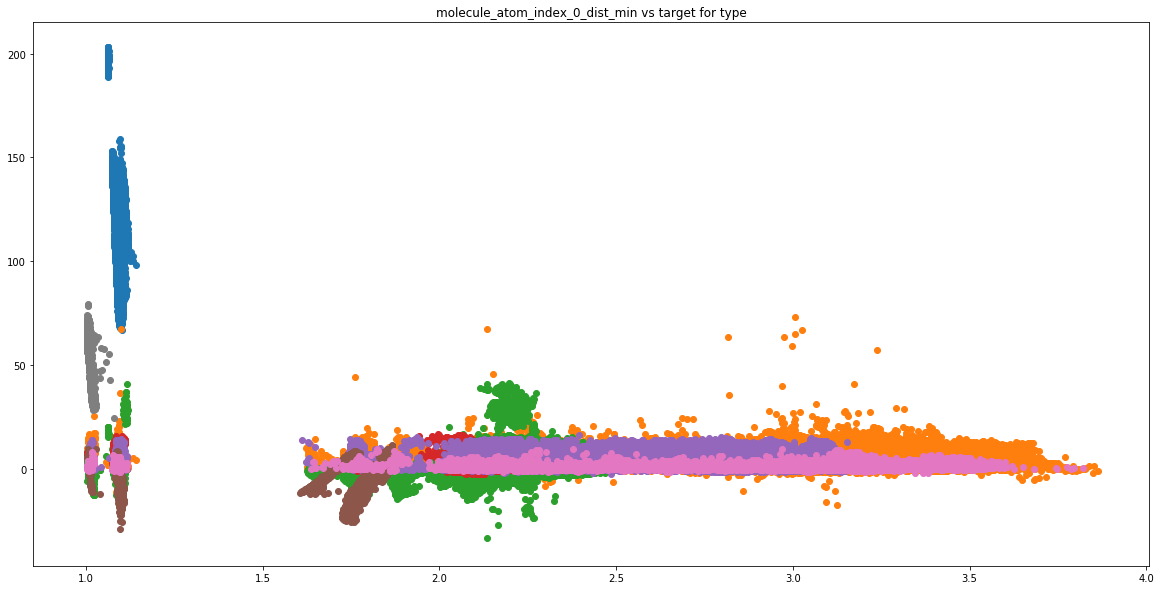

In [62]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.scatter(train.loc[train['type'] == t, good_columns[0]], train.loc[train['type'] == t, 'scalar_coupling_constant'], label=t);
plt.title(f'{good_columns[0]} vs target for type');

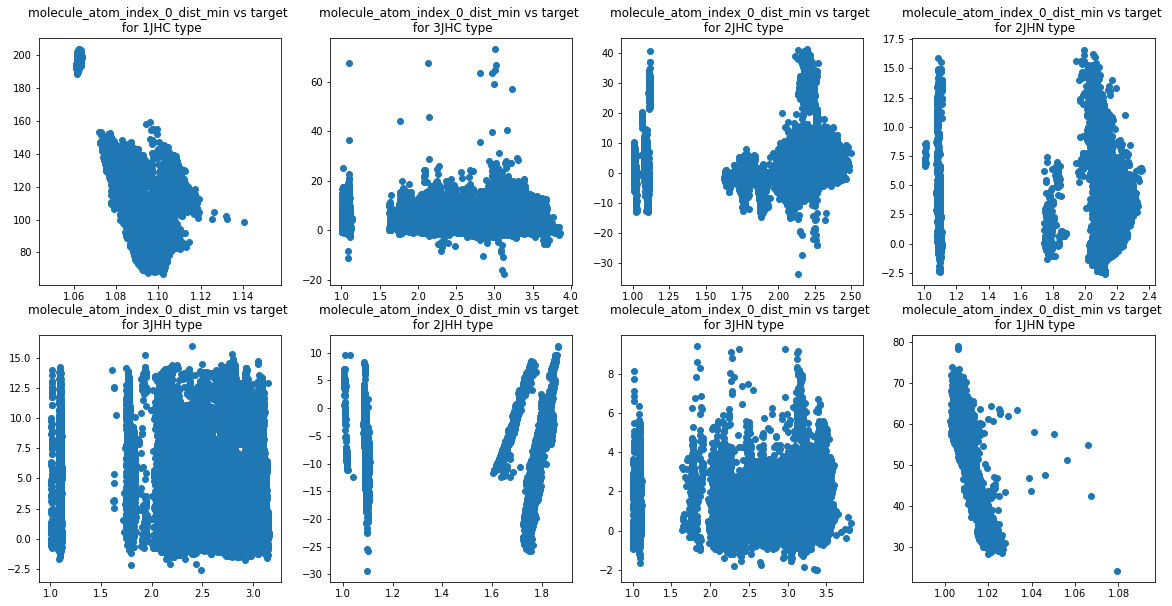

In [63]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.subplot(2, 4, i + 1);
    plt.scatter(train.loc[train['type'] == t, good_columns[0]], train.loc[train['type'] == t, 'scalar_coupling_constant'], label=t);
    plt.title(f'{good_columns[0]} vs target \n for {t} type');

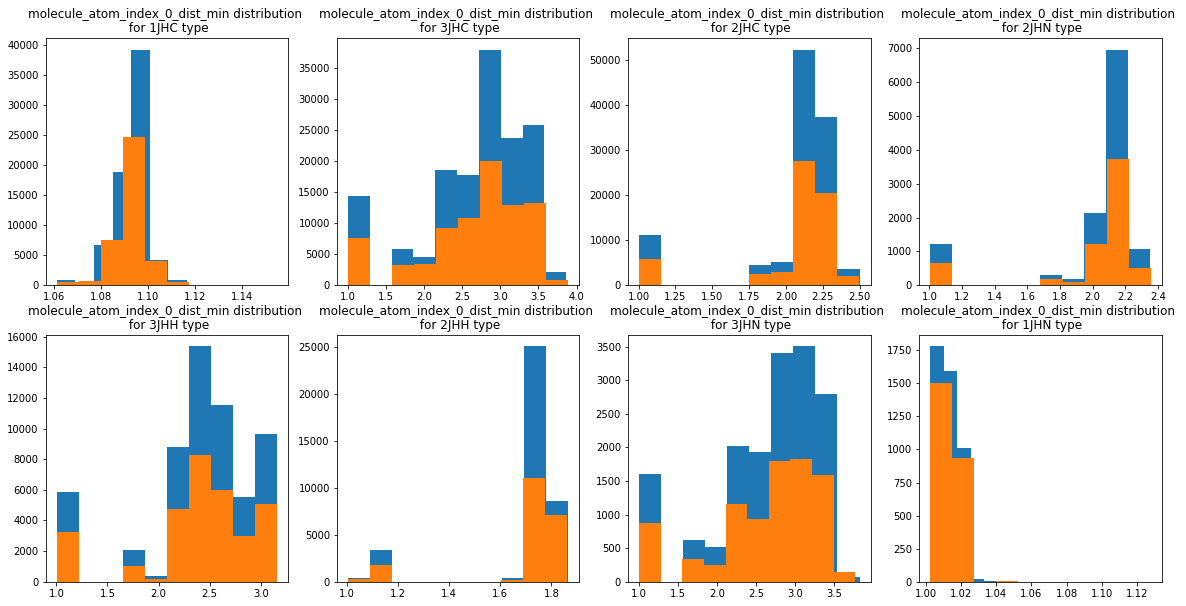

In [64]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, t in enumerate(train['type'].unique()):
    plt.subplot(2, 4, i + 1);
    plt.hist(train.loc[train['type'] == t, good_columns[0]], label='train');
    plt.hist(test.loc[test['type'] == t, good_columns[0]], label='test');
    plt.title(f'{good_columns[0]} distribution \n for {t} type');

## Prepare data for model

I'll use the function for metric calculation from this kernel: https://www.kaggle.com/abhishek/competition-metric

UPD: use faster metric from this kernel: https://www.kaggle.com/uberkinder/efficient-metric

You can see the code in my utility script. Please note that to use this metric for calculation you need to pass value `group_mae` to parameter `eval_metric`.

For now I'll simply train a single model on folds

In [65]:
for f in ['atom_1', 'type_0', 'type']:
    if f in good_columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [66]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
X_test = test[good_columns].copy()

In [67]:
del train, test

In [68]:
gc.collect()

20007

## Training model on selected features

For now I'll train model with simply 1500 estimators to check that it works.

In [69]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Wed Aug 21 09:17:21 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.85351	valid_1's l1: 2.2801
Early stopping, best iteration is:
[422]	training's l1: 1.9009	valid_1's l1: 2.2756
Fold 2 started at Wed Aug 21 09:17:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.85941	valid_1's l1: 2.30048
Early stopping, best iteration is:
[337]	training's l1: 1.96162	valid_1's l1: 2.29714
Fold 3 started at Wed Aug 21 09:17:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[228]	training's l1: 2.04913	valid_1's l1: 2.29162
CV mean score: 0.6841, std: 0.0037.


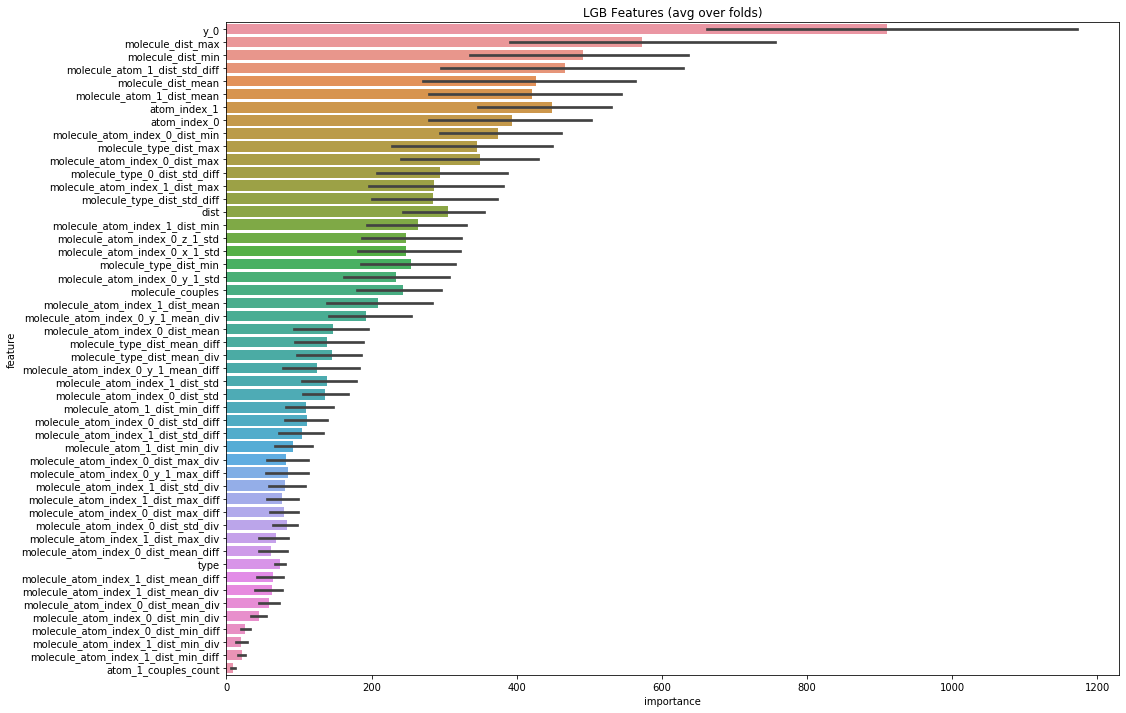

In [82]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [90]:
feature_importance = result_dict_lgb['feature_importance']
feature_importance.describe()

,importance,fold
count,153.000000000000000,153.000000000000000
mean,206.193899782135162,2.000000000000000
std,187.664850005148310,0.819178021909125
min,5.666666666666667,1.000000000000000
25%,74.666666666666671,1.000000000000000
50%,141.000000000000000,2.000000000000000
75%,295.000000000000000,3.000000000000000
max,1172.000000000000000,3.000000000000000


In [91]:
feature_importance[feature_importance.fold == 1].sort_values('importance', ascending=False)

,feature,importance,fold
31,y_0,1172.000000000000000,1
41,molecule_dist_max,756.666666666666629,1
35,molecule_dist_min,636.333333333333371,1
42,molecule_atom_1_dist_std_diff,629.666666666666629,1
21,molecule_dist_mean,563.666666666666629,1
47,molecule_atom_1_dist_mean,543.666666666666629,1
20,atom_index_1,530.333333333333371,1
40,atom_index_0,502.333333333333314,1
0,molecule_atom_index_0_dist_min,460.666666666666686,1
43,molecule_type_dist_max,448.333333333333314,1


In [98]:
important_features = feature_importance[(feature_importance.fold == 1) & (feature_importance.importance > 100)]
important_features.feature

0          molecule_atom_index_0_dist_min
1          molecule_atom_index_0_dist_max
2          molecule_atom_index_1_dist_min
3         molecule_atom_index_0_dist_mean
4          molecule_atom_index_0_dist_std
5                                    dist
6          molecule_atom_index_1_dist_std
7          molecule_atom_index_1_dist_max
8         molecule_atom_index_1_dist_mean
10     molecule_atom_index_0_dist_max_div
11    molecule_atom_index_0_dist_std_diff
15    molecule_atom_index_1_dist_std_diff
19                       molecule_couples
20                           atom_index_1
21                     molecule_dist_mean
23          molecule_atom_index_0_y_1_std
25     molecule_atom_index_1_dist_std_div
30          molecule_atom_index_0_z_1_std
31                                    y_0
32            molecule_type_dist_std_diff
33          molecule_atom_1_dist_min_diff
34          molecule_atom_index_0_x_1_std
35                      molecule_dist_min
37    molecule_atom_index_0_y_1_me

In [74]:
sub['scalar_coupling_constant'] = result_dict_lgb['prediction']
sub.to_csv('submissionTest.csv', index=False)
sub.head()

,id,scalar_coupling_constant
2366227,7024374,2.239045534255605
1291752,5949899,-0.619971249014471
1997642,6655789,-12.020701131178257
408577,5066724,198.743026569335825
830383,5488530,3.028531591073481


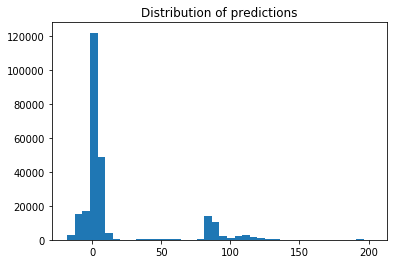

In [75]:
plt.hist(result_dict_lgb['prediction'], bins=40);
plt.title('Distribution of predictions');

## Plot oof predictions vs target

I use the code from benchmark kernel: https://www.kaggle.com/inversion/atomic-distance-benchmark

Notice that while using `LabelEncoder` on categorical variables, `type` was the last feature, so `lbl` contains encodings for it and we can inverse_transform `type`.

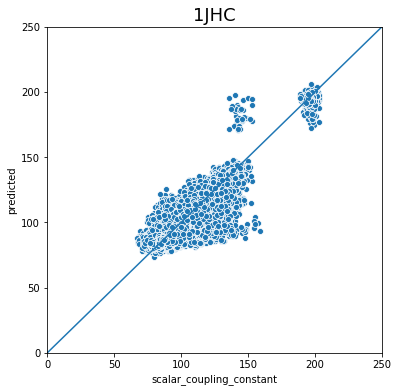

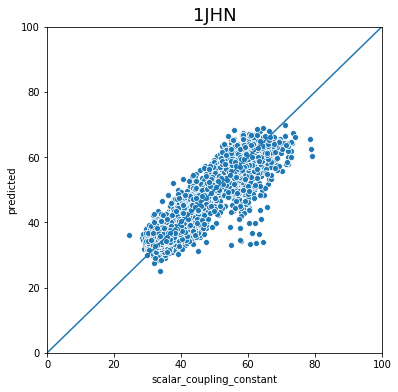

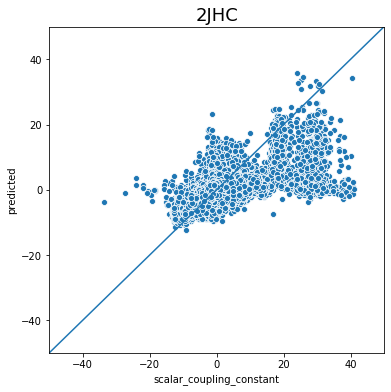

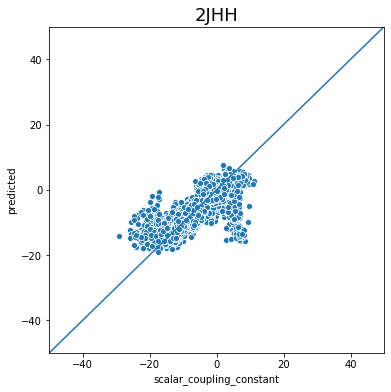

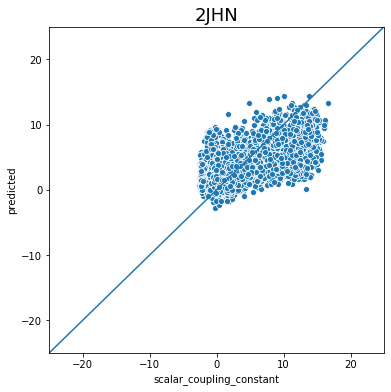

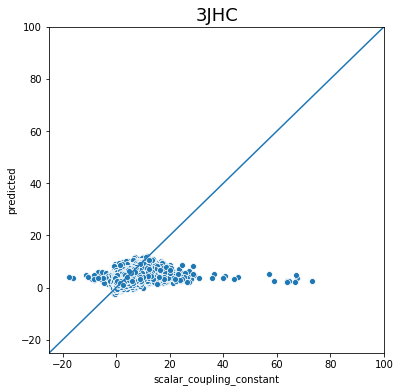

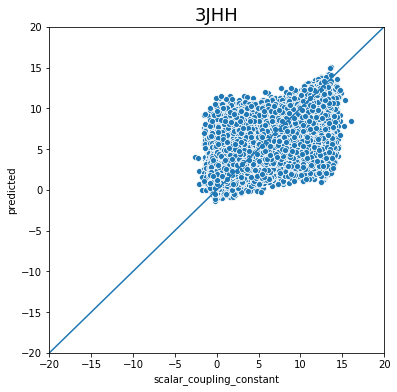

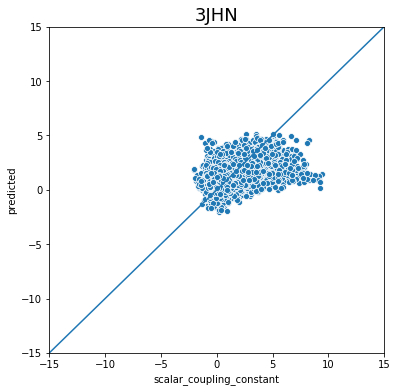

In [76]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict_lgb['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)

We can see that some types has better predictions than others. Maybe we should focus on improving models for these types?

## Training separate models for each type

We can see that different types have really different distributions of target variable, so it seems to be reasonable to build separate models for each type

Training of type 0
Fold 1 started at Wed Aug 21 09:09:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[49]	training's l1: 4.08617	valid_1's l1: 4.56553
Fold 2 started at Wed Aug 21 09:09:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[77]	training's l1: 3.94236	valid_1's l1: 4.58608
Fold 3 started at Wed Aug 21 09:09:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[64]	training's l1: 4.02495	valid_1's l1: 4.48291
CV mean score: 1.5139, std: 0.0098.
Training of type 5
Fold 1 started at Wed Aug 21 09:09:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[154]	training's l1: 1.50793	valid_1's l1: 1.79659
Fold 2 started at Wed Aug 21 09:09:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[154]	training's l1:

,id,scalar_coupling_constant
2366227,7024374,NaN
1291752,5949899,NaN
1997642,6655789,NaN
408577,5066724,NaN
830383,5488530,NaN


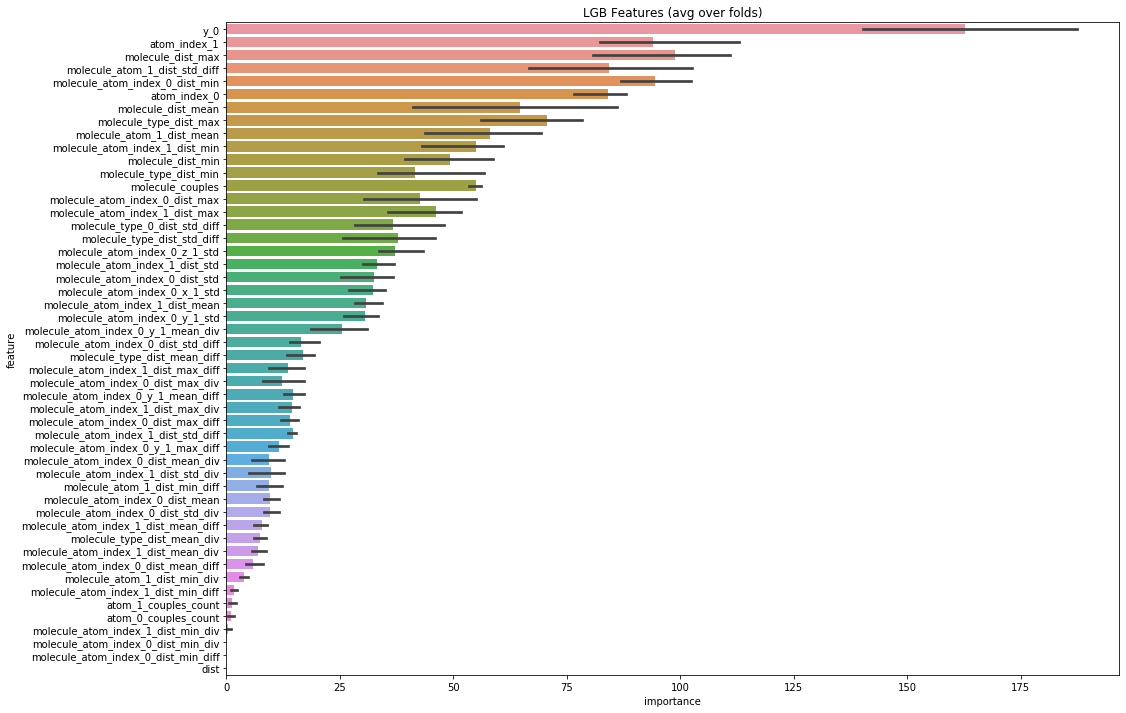

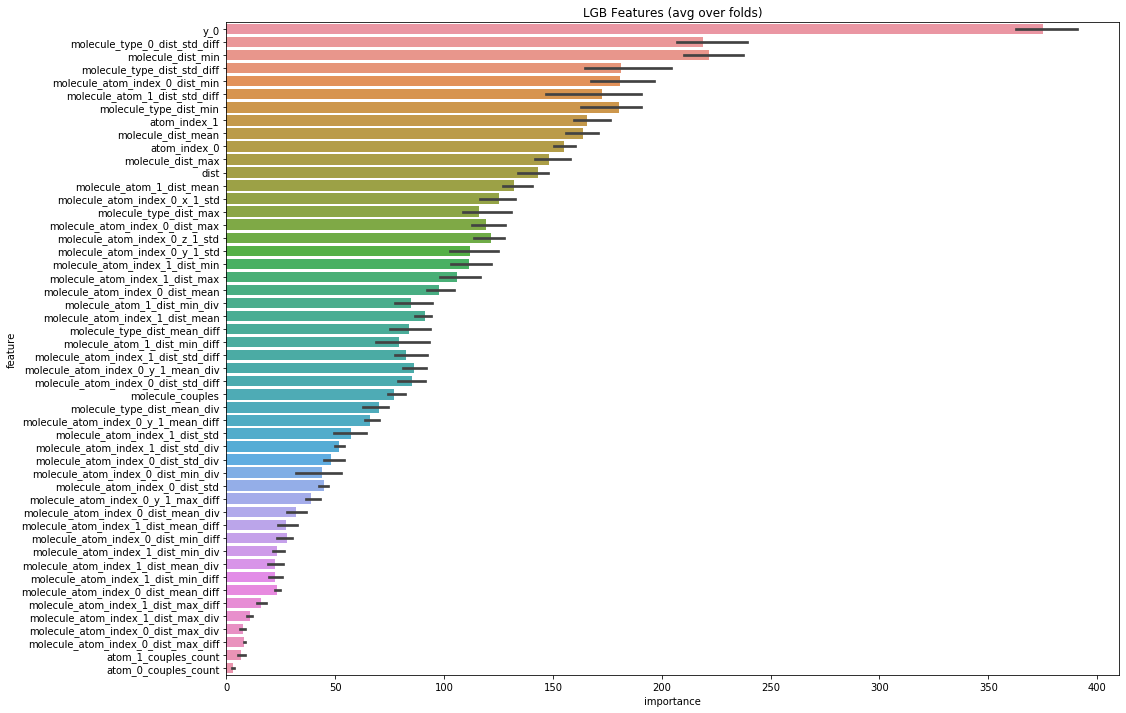

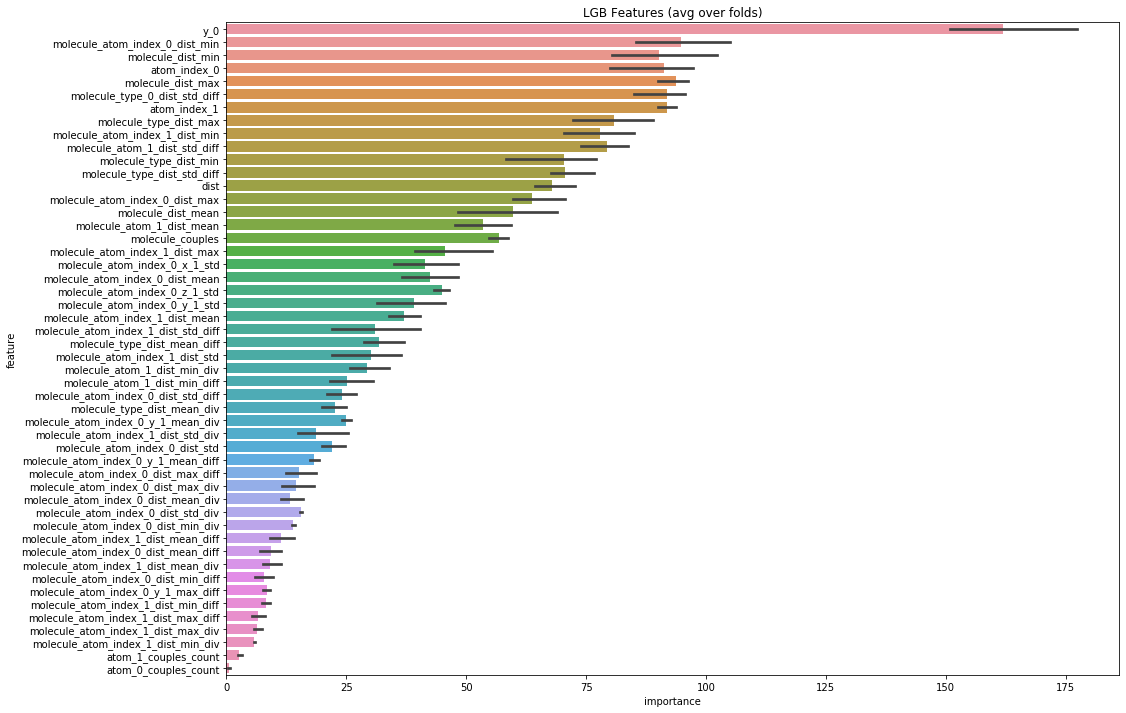

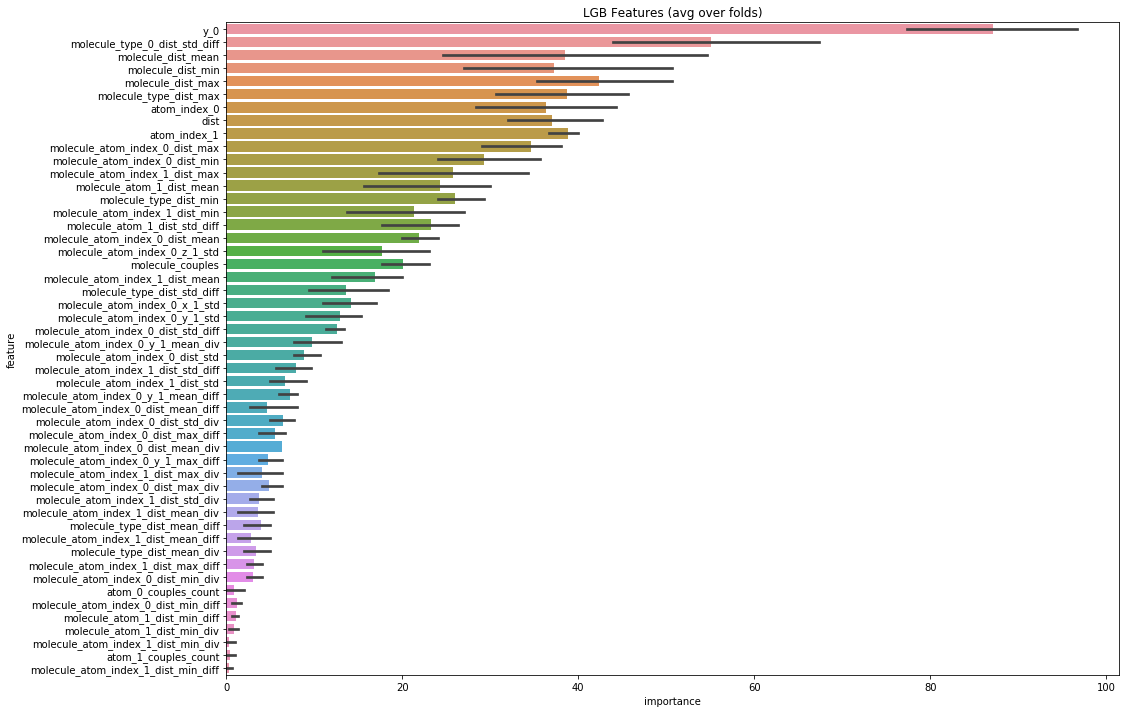

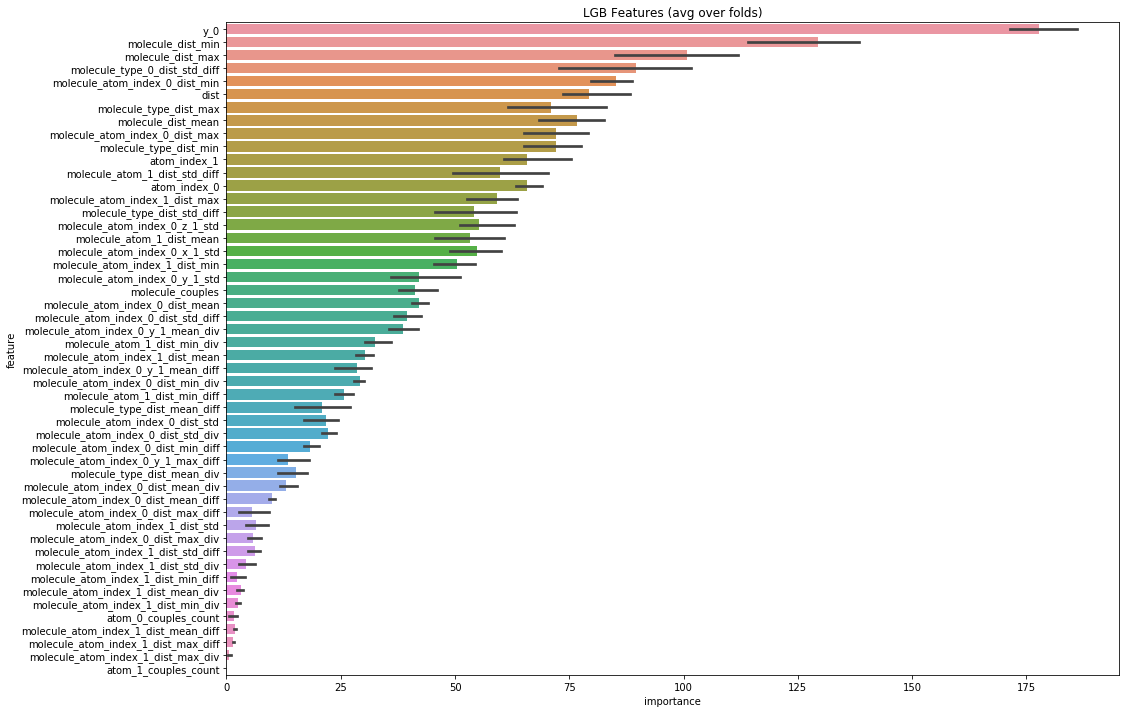

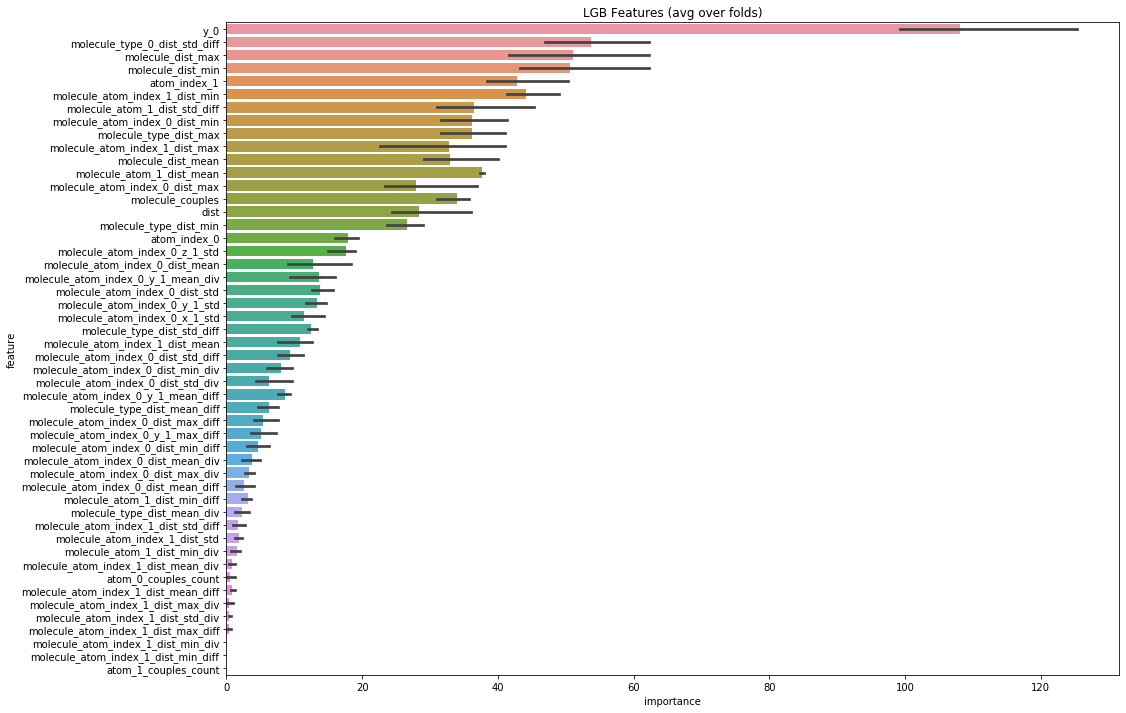

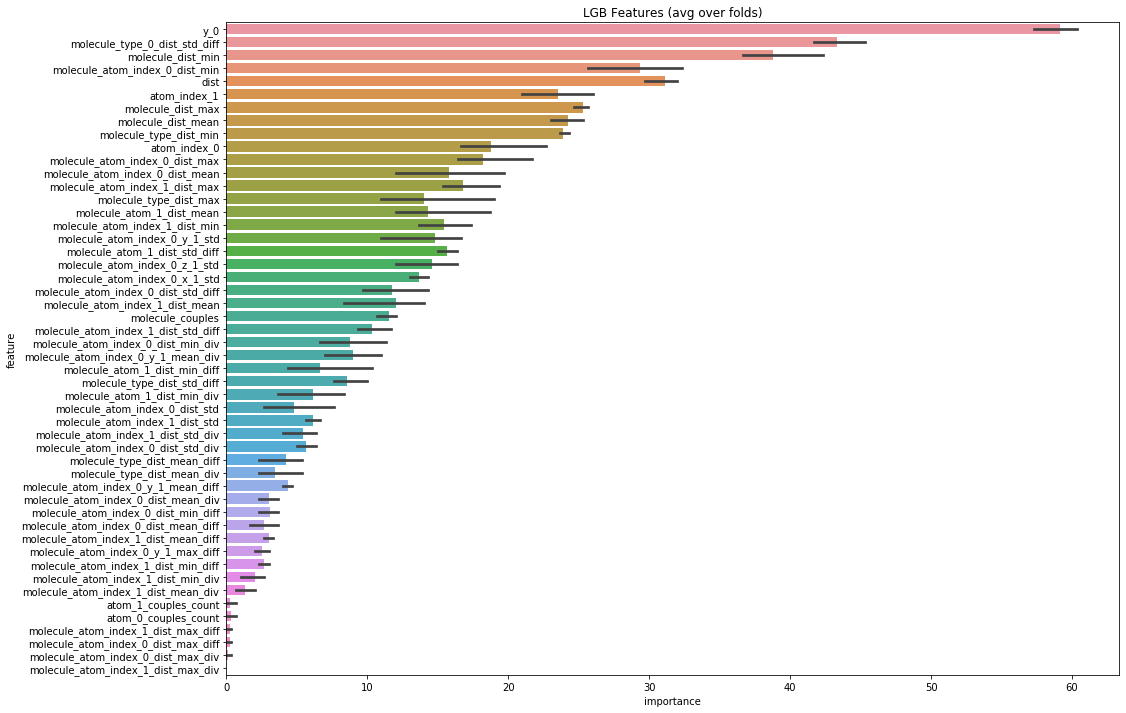

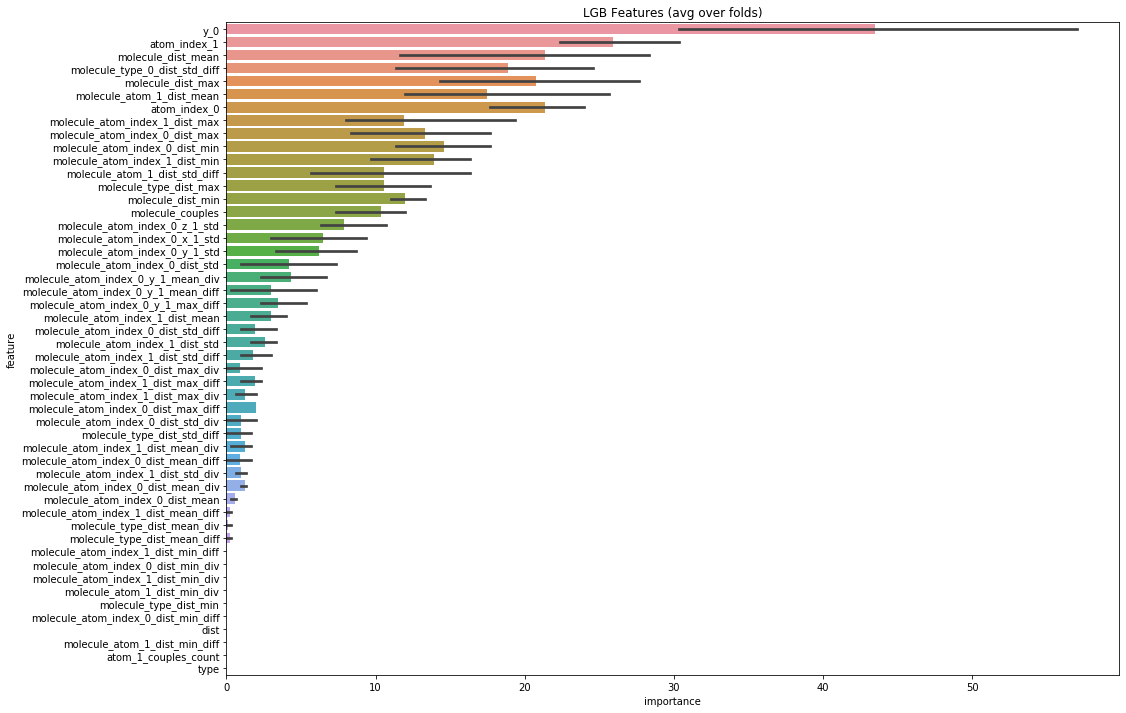

In [80]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=2000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('submission_t.csv', index=False)
sub.head()

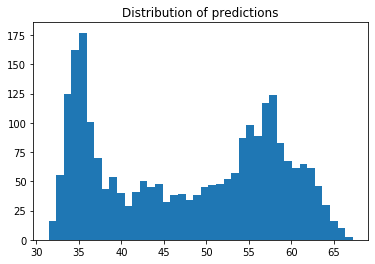

In [81]:
plt.hist(result_dict_lgb['prediction'], bins=40);
plt.title('Distribution of predictions');

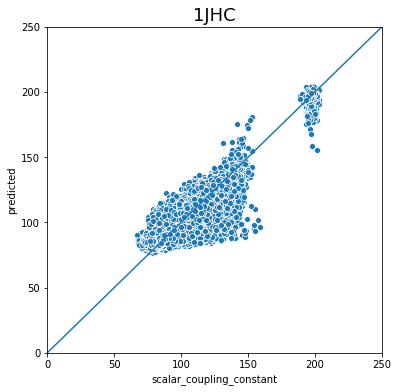

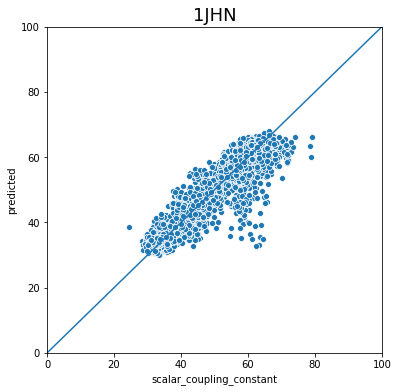

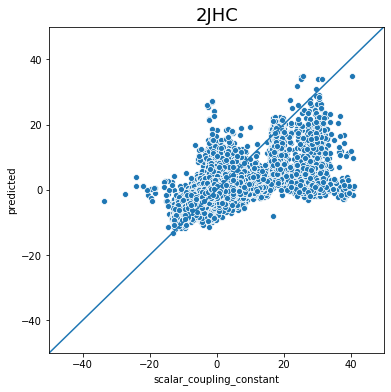

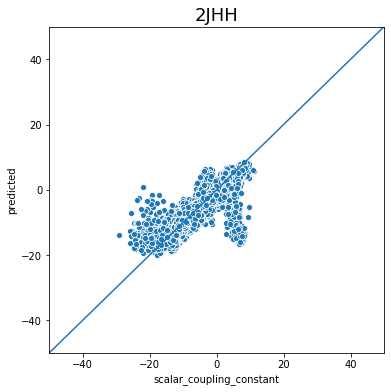

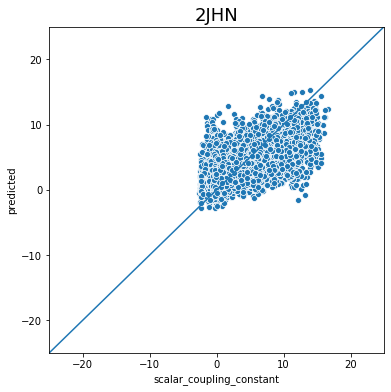

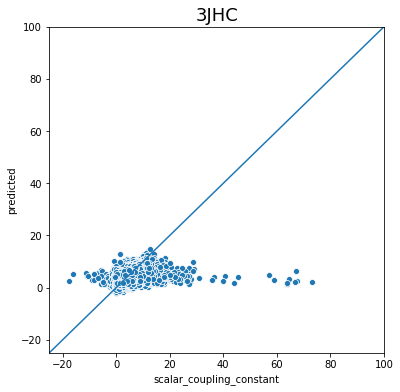

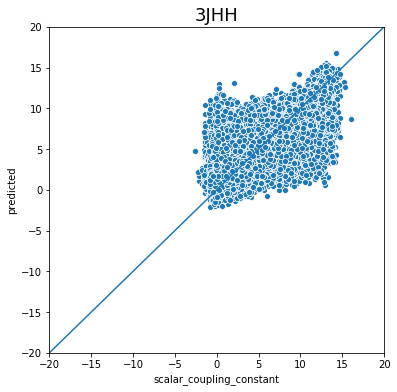

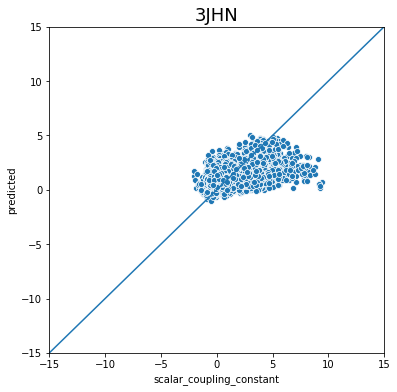

In [79]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = lbl.inverse_transform(X_short['type'])

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)